In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['ggplot'])

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone_project/cleaned_reviews.csv')
df.head()

,cleaned_reviews,rating
0,excellent,5
1,dog become healthy thank,5
2,quality service everyone happy,5
3,went top dog raw food morning first time amazi...,5
4,very stylish site enough information make choi...,5


# As the data is too large and imbalance, limiting the data to 26000 sample for class 1,2,3,4, and 52000 samples for class 5. 

In [ ]:
def get_index(x):
  
  index_1, index_2, index_3, index_4, index_5 = [], [], [], [], []
  for ind,val in enumerate(x):

    if val == 1:
      index_1.append(ind)
    elif val == 2:
      index_2.append(ind)
    elif val == 3:
      index_3.append(ind)
    elif val == 4:
      index_4.append(ind)
    else:
      index_5.append(ind)
  print(len(index_1),len(index_2), len(index_3), len(index_4), len(index_5))

  index = index_1[:26000] + index_2[:26000] + index_3[:26000] + index_4[:26000] + index_5[:26000]
  print(len(index))
  return index

In [ ]:
index = get_index(df['rating'])

97645 27398 42016 101755 925883
130000


In [ ]:
df = df.loc[index]

In [ ]:
df.head()

,cleaned_reviews,rating
88,tttsfddfhfdhdhdhdhf,1
170,pretty frustrated boyfriend decided buy one bu...,1
175,stealing money ordered coat returned still wai...,1
177,researched live chatted company credible revie...,1
178,terrible company terrible quality saddle arriv...,1


In [ ]:
count = []
for val in df['cleaned_reviews']:
    count.append(len(val.split()))
len(count)

130000

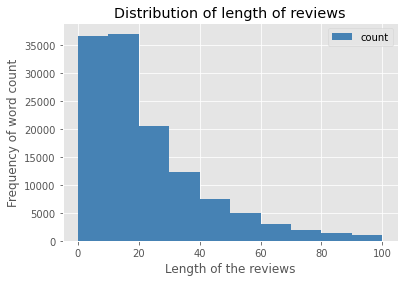

In [ ]:
sent_len = pd.DataFrame({'count':count})
sent_len.plot(kind='hist', figsize=(6, 4), color='steelblue',bins = [0,10,20,30,40,50,60,70,80,90,100])
plt.title('Distribution of length of reviews')
plt.ylabel('Frequency of word count')
plt.xlabel('Length of the reviews')

plt.show()

In [ ]:
# max len of reviews to 40
review_len40 = []
for rev in df['cleaned_reviews']:
    rev = rev.split()
    review_len40.append(' '.join(rev[0:40]))
print(review_len40[4])
df['reviews_40']= review_len40

terrible company terrible quality saddle arrived totally flat malformed would not return without paying shipping file credit card dispute saddle shipped flat saddle arrived looking completely flat course wide one person working office rude total waste money bad quality no


In [ ]:
df.head()

,cleaned_reviews,rating,reviews_40
88,tttsfddfhfdhdhdhdhf,1,tttsfddfhfdhdhdhdhf
170,pretty frustrated boyfriend decided buy one bu...,1,pretty frustrated boyfriend decided buy one bu...
175,stealing money ordered coat returned still wai...,1,stealing money ordered coat returned still wai...
177,researched live chatted company credible revie...,1,researched live chatted company credible revie...
178,terrible company terrible quality saddle arriv...,1,terrible company terrible quality saddle arriv...


In [ ]:
tf_idf_vec = TfidfVectorizer(max_features=7000)
bag_words = tf_idf_vec.fit_transform(df['reviews_40']).toarray().astype(np.float32)

In [ ]:
target = df['rating'].to_numpy().astype(np.int16)

In [ ]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/tf_idf_7000.npz', bag_words)
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/tf_idf_target7000.npz', target)

NameError: ignored

# Creating a chain of models, i.e The first model will be predicting 3 classes, class 1, 2 as class 1, class 3,4 as class 2, and class 5 as class 3. After the predictions from model 1, the samples predicted as class 1 will be given to model 2, this model will precdict the original class of the samples (1,2). Model 3 will predict for class 2 from model 1 into original classes 3,4. The final metrics will take output from model 1 (class 3-->5) and model 2 (class 1,2 --> 1,2,3,4).

# loading the saved tf-idf vectors.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import classification_report # precision, recall, f1


In [ ]:
tf_idf = np.load('/content/drive/My Drive/Colab Notebooks/tf_idf_7000.npz')

tf_idf = tf_idf['arr_0']

In [ ]:
# Target data 

target = np.load('/content/drive/My Drive/Colab Notebooks/tf_idf_target7000.npz')

target = target['arr_0']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, target, test_size=0.33, random_state=42)

# mapping the targets.
# 1,2 --> 1, 3,4--> 2, 5--> 3

In [ ]:
def target_mapping(x):

  map_1 = [0] * len(x)
  map_2 = [] 
  map_3 = []  

  for ind, val in enumerate(x):

    if val == 2 or val == 1:
      map_1[ind] = 1
      map_2.append(ind)
    elif val == 3 or val == 4:
      map_1[ind] = 2
      map_3.append(ind)
    else:
      map_1[ind] = 3
  
  return np.array(map_1), map_2, map_3

In [ ]:
y_train_m1, train_index_1_2, train_index_3_4 = target_mapping(y_train)
y_test_m1, test_index_1_2, test_index_3_4 = target_mapping(y_test)

# Model 1 having 3 classes.

In [ ]:
# Naive Bayes 

clf = MultinomialNB()

# Training the model on the udersampled data.

clf.fit(X_train, y_train_m1)

# Prediction on the 
pred = clf.predict(X_test)

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test_m1, pred))

# Precision, Recall, F1-score 
print(classification_report(y_test_m1, pred))

[[11170  5253   820]
 [ 4118 11510  1578]
 [  649  2629  5173]]
              precision    recall  f1-score   support

           1       0.70      0.65      0.67     17243
           2       0.59      0.67      0.63     17206
           3       0.68      0.61      0.65      8451

    accuracy                           0.65     42900
   macro avg       0.66      0.64      0.65     42900
weighted avg       0.65      0.65      0.65     42900



In [ ]:
X_train_1_2 = X_train[train_index_1_2]
y_train_1_2 = y_train[train_index_1_2]

# Model 2 trained on classes 1,2

In [ ]:
clf2 = MultinomialNB()

clf2.fit(X_train_1_2, y_train_1_2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
index_m1_1=[]
for ind,val in enumerate(pred):
  if val == 1:
    index_m1_1.append(ind)

# Model 2 test data, having classes 1,2

In [ ]:
X_test_1_2 = X_test[index_m1_1]

In [ ]:
#y_test_1_2 = y_test[test_index_1_2]

In [ ]:
pred2 = clf2.predict(X_test_1_2)

# Model 3, trained on classes 3,4

In [ ]:
X_train_3_4 = X_train[train_index_3_4]
y_train_3_4 = y_train[train_index_3_4]

In [ ]:
clf3 = MultinomialNB()

clf3.fit(X_train_3_4, y_train_3_4)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
index_m1_2=[]
for ind,val in enumerate(pred):
  if val == 2:
    index_m1_2.append(ind)

# Test data for model 3

In [ ]:
X_test_3_4 = X_test[index_m1_2]

In [ ]:
pred3 = clf3.predict(X_test_3_4)

# In order to calculate the perform of all the models, changing the pred array to original classes.

In [ ]:
pred[pred == 3] = 5

In [ ]:
for ind, val in enumerate(pred3):
  pred[index_m1_2[ind]] = val

In [ ]:
for ind, val in enumerate(pred2):
  pred[index_m1_1[ind]] = val

In [ ]:
np.unique(pred)

array([1, 2, 3, 4, 5])

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, pred))

# Precision, Recall, F1-score 
print(classification_report(y_test, pred))

[[5338  737  749 1285  419]
 [2202 2893 1732 1487  401]
 [1346 1500 2838 2395  507]
 [ 761  511 1514 4763 1071]
 [ 371  278  443 2186 5173]]
              precision    recall  f1-score   support

           1       0.53      0.63      0.58      8528
           2       0.49      0.33      0.40      8715
           3       0.39      0.33      0.36      8586
           4       0.39      0.55      0.46      8620
           5       0.68      0.61      0.65      8451

    accuracy                           0.49     42900
   macro avg       0.50      0.49      0.49     42900
weighted avg       0.50      0.49      0.49     42900



# The final confusion matrix and report. It is seen that this model is able to predict class 2,3,4 better than other models. There is no improvement in the final accuracy.

In [ ]:
np.unique(y_test)

array([1, 2, 3, 4, 5], dtype=int16)

In [ ]:
np.unique(y, return_counts=True)

(array([1, 2, 3]), array([10000, 13000, 17549]))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler #undersampling

# Undersampling object
rus = RandomUnderSampler(sampling_strategy={1:5000,2:5000,3:3000},random_state=0)
def under_sample(x,y):
    
    X_resampled, y_resampled = rus.fit_resample(x,y)
    return X_resampled, y_resampled

In [ ]:
y, ytp, ytp1 = target_mapping(y_train)
X,y = under_sample(X_train,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
yt,ytp, ytp1 = target_mapping(y_test)

In [ ]:
# Naive Bayes 

clf4 = MultinomialNB()

# Training the model on the udersampled data.

clf4.fit(X, y)

# Prediction on the 
pred4 = clf4.predict(X_test)

In [ ]:
# Confusion Matrix
print(confusion_matrix(yt, pred4))

# Precision, Recall, F1-score 
print(classification_report(yt, pred4))

[[11259  5285   699]
 [ 4527 11335  1344]
 [  832  3090  4529]]
              precision    recall  f1-score   support

           1       0.68      0.65      0.67     17243
           2       0.58      0.66      0.61     17206
           3       0.69      0.54      0.60      8451

    accuracy                           0.63     42900
   macro avg       0.65      0.62      0.63     42900
weighted avg       0.64      0.63      0.63     42900



In [ ]:
n_right = 0
for i in range(len(pred4)):
    if pred4[i] == yt[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(yt)) * 100)))

Accuracy: 63.22%


In [ ]:
from sklearn.svm import SVC

In [ ]:
 clf5 = SVC(kernel='linear').fit(X, y)
 pred5 = clf5.predict(X_test)

In [ ]:
n_right = 0
for i in range(len(pred5)):
    if pred5[i] == yt[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(yt)) * 100)))

Accuracy: 63.26%


In [ ]:
# Confusion Matrix
print(confusion_matrix(yt, pred5))

# Precision, Recall, F1-score 
print(classification_report(yt, pred5))

[[10831  5239  1173]
 [ 4298 10734  2174]
 [  723  2153  5575]]
              precision    recall  f1-score   support

           1       0.68      0.63      0.65     17243
           2       0.59      0.62      0.61     17206
           3       0.62      0.66      0.64      8451

    accuracy                           0.63     42900
   macro avg       0.63      0.64      0.63     42900
weighted avg       0.64      0.63      0.63     42900



# Tried using other algorithms on 3 classes, as the first model does not make better prediction than the Naive Bayes it is not useful to create chain of models.